In [1]:
dir("../../")

[1] "app"        "data"       "docs"       "log"        "notebooks" 
 [6] "README.md"  "references" "results"    "scripts"    "site"      
[11] "tests"      "tmp"

In [2]:
fdiry = "../../scripts"
fname = "config_project_sing.R"
fpath = file.path(fdiry, fname)

suppressMessages(suppressWarnings(source(fpath)))
suppressMessages(suppressWarnings(library("DESeq2")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/work 
CODE DIRECTORY (FD_REPO): /data/reddylab/Kuei/repo 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/repo/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_DAT): /data/reddylab/Kuei/work/proj_combeffect_encode_fcc/data 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/work/proj_combeffect_encode_fcc/results 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/work/proj_combeffect_encode_fcc/log 


In [3]:
print(FD_RES)
FD_RES = "/data/reddylab/Kuei/work/proj_combeffect_encode_fcc/results_v4"
print(FD_RES)

[1] "/data/reddylab/Kuei/work/proj_combeffect_encode_fcc/results"
[1] "/data/reddylab/Kuei/work/proj_combeffect_encode_fcc/results_v4"


In [4]:
dir(FD_RES)

[1] "A001_K562_WSTARRseq"          "comparison"                  
 [3] "comparison_archive231029"     "CRISPRi_FlowFISH"            
 [5] "CRISPRi_Growth_K562_Gersbach" "hic_intact_K562_deep"        
 [7] "hic_intact_K562_ENCSR479XDG"  "KS91_K562_ASTARRseq"         
 [9] "LentiMPRA_K562_Nadav"         "region"                      
[11] "Tewhey_K562_TileMPRA"

In [5]:
PREFIX = "KS91_K562_ASTARRseq"
FOLDER = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, PREFIX, FOLDER, "summary")
for(txt in dir(fdiry)){print(txt)}

[1] "matrix.raw.count.WGS.tsv"
[1] "matrix.raw.cpm.WGS.tsv"
[1] "metadata.raw.WGS.tsv"
[1] "result.Log2FC.raw.cpm.WGS.tsv"
[1] "result.Log2FC.raw.deseq.WGS.tsv"
[1] "result.score.raw.cpm.WGS.tsv"


In [6]:
PREFIX = "KS91_K562_ASTARRseq"
FOLDER = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, PREFIX, FOLDER, "summary")

fname = "matrix.raw.count.WGS.tsv"
fpath = file.path(fdiry, fname)
dat_count = read_tsv(fpath, show_col_types = FALSE)

fname = "metadata.raw.WGS.tsv"
fpath = file.path(fdiry, fname)
dat_meta = read_tsv(fpath, show_col_types = FALSE)

**Arrange count matrix and metadata**

In [7]:
dat_col = dat_meta  %>% 
    dplyr::select(Sample, Group) %>% 
    dplyr::rename(condition = Group) %>%
    column_to_rownames(var = "Sample")

dat_cnt = dat_count %>% 
    column_to_rownames(var = "Peak")

dat_cnt[is.na(dat_cnt)] = 0

**Show data**

In [8]:
head(dat_cnt)

,Input.rep1,Input.rep2,Input.rep3,Input.rep4,Input.rep5,Input.rep6,Output.rep1,Output.rep2,Output.rep3,Output.rep4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1:100006256-100006880,121,176,180,155,147,152,10,32,24,51
chr1:100010437-100010915,103,122,125,146,123,119,2,9,15,28
chr1:10002087-10003910,399,561,538,546,536,458,28,77,70,127
chr1:100021298-100021629,79,106,121,106,96,92,2,7,12,16
chr1:100023727-100023976,48,72,72,68,79,57,11,11,7,14
chr1:100027983-100029702,480,611,744,697,676,573,37,108,110,165


In [9]:
dat_col

,condition
,<chr>
Input.rep1,Input
Input.rep2,Input
Input.rep3,Input
Input.rep4,Input
Input.rep5,Input
Input.rep6,Input
Output.rep1,Output
Output.rep2,Output
Output.rep3,Output


In [10]:
print(all(rownames(dat_col) %in% colnames(dat_cnt)))
print(all(rownames(dat_col) ==   colnames(dat_cnt)))

[1] TRUE
[1] TRUE


## Setup DESeq2

In [11]:
dds = DESeqDataSetFromMatrix(
    countData = dat_cnt, 
    colData   = dat_col, 
    design    = ~condition)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


**Pre-filtering**

In [12]:
### remove the peaks which have < 10 reads
cat("Before filter:", nrow(dds), "\n")
dds = dds[rowSums(counts(dds)) >= 10,]
cat("After  filter:", nrow(dds), "\n")

### set control condition as reference
dds$condition <- relevel(dds$condition, ref = "Input")

Before filter: 246852 
After  filter: 246850 


## Run DESeq2

In [13]:
dds = DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Get results

In [14]:
resultsNames(dds)

[1] "Intercept"                 "condition_Output_vs_Input"

In [15]:
res = results(dds)
dat = as.data.frame(res) %>% rownames_to_column(var = "Peak")

cat("After Deseq2.results:", nrow(dat), "\n")
head(dat)

After Deseq2.results: 246850 


,Peak,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:100006256-100006880,74.39238,-0.01311792,0.15512423,-0.08456397,9.326080e-01,0.9510236543
2,chr1:100010437-100010915,48.25931,-0.80687947,0.22174651,-3.63874709,2.739677e-04,0.0008947519
3,chr1:10002087-10003910,224.35927,-0.34892859,0.09743886,-3.58100041,3.422811e-04,0.0010926173
4,chr1:100021298-100021629,38.13434,-1.03799571,0.25401013,-4.08643436,4.380534e-05,0.0001707736
5,chr1:100023727-100023976,32.62049,-0.19100207,0.25625467,-0.74536036,4.560539e-01,0.5497617125
6,chr1:100027983-100029702,290.98442,-0.18001582,0.09610434,-1.87312902,6.105057e-02,0.1032752224


```
Before filter:         246852 
After  filter:         246850
After  Deseq2.results: 246850
```

In [17]:
metadata(res)

,theta,numRej
,<dbl>,<dbl>
0%,0.00000000,145092
1.938776%,0.01938776,142061
3.877551%,0.03877551,140279
5.816327%,0.05816327,138486
7.755102%,0.07755102,136622
9.693878%,0.09693878,134697
11.63265%,0.11632653,132734
13.57143%,0.13571429,130672
15.5102%,0.15510204,128617


In [18]:
num = metadata(res)$alpha
print(num)
num = metadata(res)$filterThreshold
print(num)

[1] 0.1
      0% 
17.61199 


DESeq2 has filtered out genes with a mean count of 17.61. As a result, 0% of genes were filtered out of the analysis.

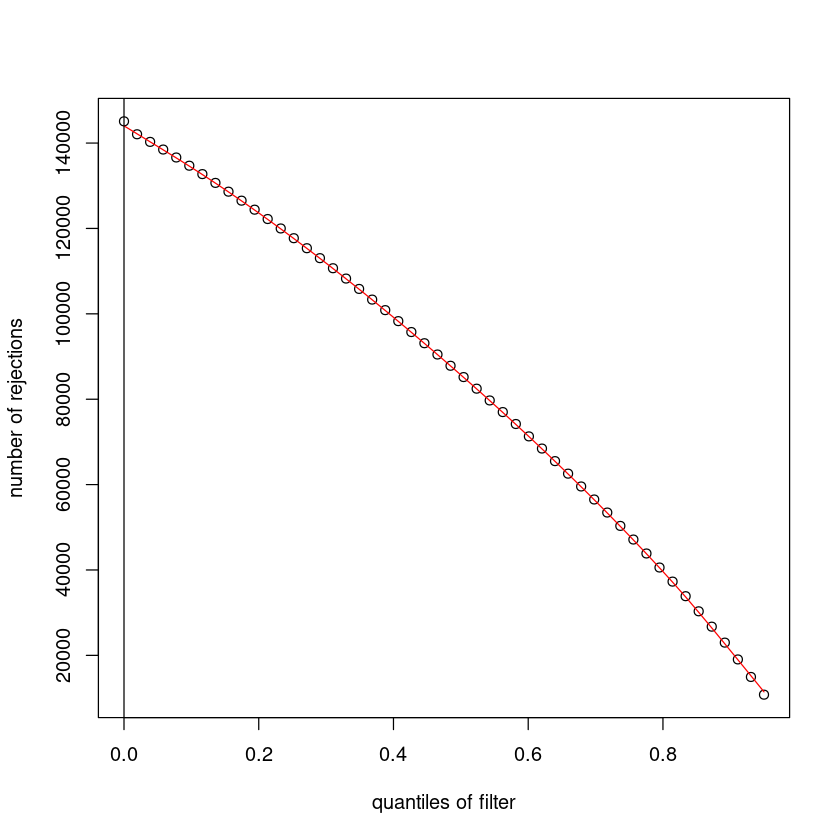

In [16]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [19]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,101758,0,101758
TRUE,0,145092,145092
Sum,101758,145092,246850
